In [122]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Add,
    Input
)
from tensorflow.keras.preprocessing.image import (
    img_to_array,
    array_to_img,
    ImageDataGenerator
)

import matplotlib.pyplot as plt
%matplotlib inline

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [30]:
def drop_resolution(x, scale=3.0):
    size = (x.shape[0], x.shape[1])
    small_size = (int(size[0]/scale), int(size[1]/scale))
    img = array_to_img(x)
    small_img = img.resize(small_size, 3)
    return img_to_array(small_img.resize(img.size, 3))

In [31]:
def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
    generator = ImageDataGenerator().flow_from_directory(
        directory=data_dir,
        classes=[mode],
        class_mode=None,
        color_mode='rgb',
        target_size=target_size,
        batch_size=batch_size,
        shuffle=shuffle
    )
    
    for imgs in generator:
        x = np.array([
            drop_resolution(img, scale) for img in imgs
        ])
        
        yield x/255., imgs/255.

In [32]:
DATA_DIR = '../data/chap10/data/chap10/'
N_TRAIN_DATA = 1000
N_TEST_DATA = 1000
BATCH_SIZE = 32

train_gen = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)
test_gen = data_generator(DATA_DIR, 'test', batch_size=N_TEST_DATA, shuffle=False)

test_x, test_y = next(test_gen)

## goal
- generate sharp and high resolution image
- input: blurred, low resolution image

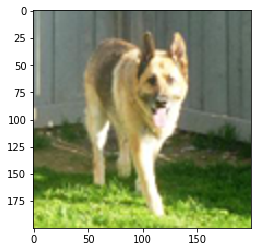

In [42]:
plt.imshow(test_x[0, :])

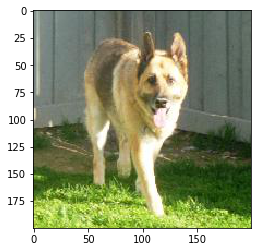

In [41]:
plt.imshow(test_y[0, :])

## build network
- based on [Image Super-Resolution Using Deep Convolutional Networks]


[Image Super-Resolution Using Deep Convolutional Networks]: https://arxiv.org/abs/1501.00092

In [44]:
model = Sequential()

In [45]:
model.add(
    Conv2D(
        filters=64,
        kernel_size=(9, 9),
        padding='same',
        activation='relu',
        input_shape=(None, None, 3)
    )
)
model.add(
    Conv2D(
        filters=32,
        kernel_size=(1, 1),
        padding='same',
        activation='relu',
    )
)
model.add(
    Conv2D(
        filters=3,
        kernel_size=(5, 5),
        padding='same',
    )
)

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


## error metrics
[PSNR: Peak signal-to-noise ratio]

$$PSNR = 10log_{10}\frac{MAX^2}{MSE}$$
- Notations
    - MAX: max value target image can have (1.0 for this case)
    - MSE: mean squared error
- generally 20dB ~ 50dB is good for super resolution problem


[PSNR: Peak signal-to-noise ratio]: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

In [74]:
def psnr(y_true, y_pred):
    return -10*tf.math.log(tf.keras.backend.mean(tf.square(y_true - y_pred))) / np.log(10)

In [75]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[psnr]
)

In [78]:
model.fit_generator(
    train_gen,
    validation_data=(test_x, test_y),
    steps_per_epoch=int(N_TRAIN_DATA/BATCH_SIZE),
    epochs=50
)

Epoch 1/50
Found 1000 images belonging to 1 classes.
31/31 [==============================] - 7s 213ms/step - loss: 0.0286 - psnr: 16.7776 - val_loss: 0.0135 - val_psnr: 18.8445
Epoch 2/50
31/31 [==============================] - 4s 115ms/step - loss: 0.0087 - psnr: 20.6908 - val_loss: 0.0092 - val_psnr: 20.5990
Epoch 3/50
31/31 [==============================] - 3s 103ms/step - loss: 0.0065 - psnr: 21.9246 - val_loss: 0.0080 - val_psnr: 21.2680
Epoch 4/50
31/31 [==============================] - 3s 104ms/step - loss: 0.0058 - psnr: 22.4321 - val_loss: 0.0076 - val_psnr: 21.4626
Epoch 5/50
31/31 [==============================] - 3s 104ms/step - loss: 0.0054 - psnr: 22.7340 - val_loss: 0.0071 - val_psnr: 21.8046
Epoch 6/50
31/31 [==============================] - 3s 104ms/step - loss: 0.0051 - psnr: 23.0101 - val_loss: 0.0064 - val_psnr: 22.2791
Epoch 7/50
31/31 [==============================] - 3s 104ms/step - loss: 0.0051 - psnr: 22.9875 - val_loss: 0.0064 - val_psnr: 22.2914
Epoch 

In [79]:
pred = model.predict(test_x)

In [103]:
def display_image(input_img, pred_img, true_img, idx=0):
    fig, ax_arr = plt.subplots(1, 3)
    
    titles = ['Input Image', 'Predict Image', 'True Image']
    
    for i, img in enumerate([input_img[idx], pred_img[idx], true_img[idx]]):
        ax = ax_arr[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(titles[i], fontsize=15)
        
    fig.subplots_adjust(right=2, top=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


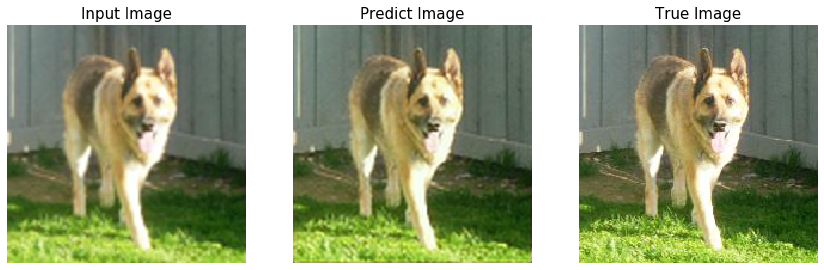

In [113]:
display_image(test_x, pred, test_y, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


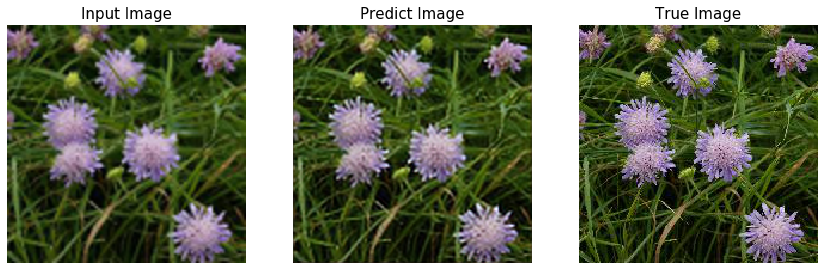

In [118]:
display_image(test_x, pred, test_y, 75)

## build network
- based on [Image Restoration Using Convolutional Auto-encoders with Symmetric Skip Connections]


[Image Restoration Using Convolutional Auto-encoders with Symmetric Skip Connections]: https://arxiv.org/abs/1606.08921

In [123]:
inputs = Input((None, None, 3), dtype='float')

In [129]:
# Encoder
conv1 = Conv2D(64, kernel_size=(3, 3), padding='same')(inputs)
conv1 = Conv2D(64, kernel_size=(3, 3), padding='same')(conv1)

conv2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), padding='same')(conv2)

conv3 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), padding='same')(conv3)

# Decoder
deconv3 = Conv2DTranspose(64, kernel_size=(3, 3), padding='same')(conv3)
deconv3 = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(deconv3)

# skipped connection
merge2 = Add()([deconv3, conv2])
deconv2 = Conv2DTranspose(64, kernel_size=(3, 3), padding='same')(merge2)
deconv2 = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same')(deconv2)

merge1 = Add()([deconv2, conv1])
deconv1 = Conv2DTranspose(64, kernel_size=(3, 3), padding='same')(merge1)
deconv1 = Conv2DTranspose(3, kernel_size=(3, 3), padding='same')(deconv1)

output = Add()([deconv1, inputs])

model = Model(inputs, output)

In [137]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, None, None, 6 36928       conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, None, 6 36928       conv2d_8[0][0]                   
______________________________________________________________________________________________

In [138]:
DATA_DIR = '../data/chap10/data/chap10/'
N_TRAIN_DATA = 1000
N_TEST_DATA = 1000
BATCH_SIZE = 32

train_gen = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)
test_gen = data_generator(DATA_DIR, 'test', batch_size=N_TEST_DATA, shuffle=False)

In [139]:
test_x, test_y = next(test_gen)

Found 100 images belonging to 1 classes.


In [141]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=[psnr]
)

In [142]:
model.fit_generator(
    train_gen,
    validation_data=(test_x, test_y),
    steps_per_epoch=int(N_TRAIN_DATA/BATCH_SIZE),
    epochs=50
)

Epoch 1/50
31/31 [==============================] - 12s 382ms/step - loss: 0.0550 - psnr: 18.4314 - val_loss: 0.0071 - val_psnr: 21.7499
Epoch 2/50
31/31 [==============================] - 9s 296ms/step - loss: 0.0043 - psnr: 23.7383 - val_loss: 0.0055 - val_psnr: 23.0087
Epoch 3/50
31/31 [==============================] - 9s 297ms/step - loss: 0.0039 - psnr: 24.2324 - val_loss: 0.0053 - val_psnr: 23.1669
Epoch 4/50
31/31 [==============================] - 9s 298ms/step - loss: 0.0039 - psnr: 24.2093 - val_loss: 0.0052 - val_psnr: 23.2304
Epoch 5/50
31/31 [==============================] - 9s 298ms/step - loss: 0.0038 - psnr: 24.3329 - val_loss: 0.0051 - val_psnr: 23.3176
Epoch 6/50
31/31 [==============================] - 9s 299ms/step - loss: 0.0037 - psnr: 24.3350 - val_loss: 0.0050 - val_psnr: 23.3930
Epoch 7/50
31/31 [==============================] - 9s 299ms/step - loss: 0.0036 - psnr: 24.4498 - val_loss: 0.0050 - val_psnr: 23.4212
Epoch 8/50
31/31 [=============================

In [143]:
pred = model.predict(test_x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


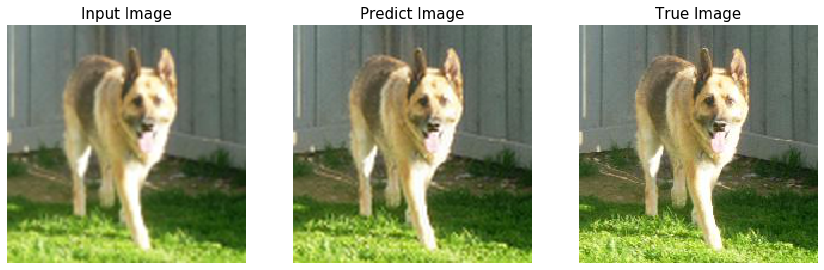

In [144]:
display_image(test_x, pred, test_y, 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


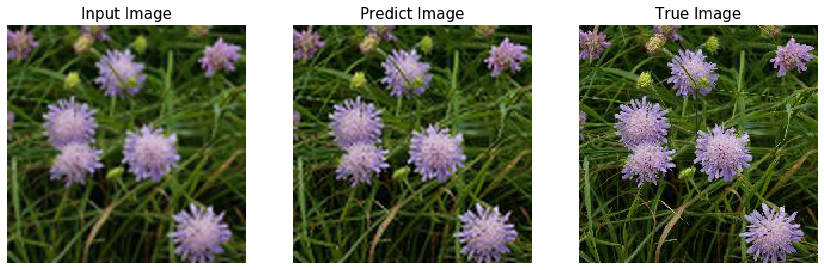

In [145]:
display_image(test_x, pred, test_y, 75)